# Image Caption Generator Using Cnn and LSTM

# What is Image Caption Generator?
Image caption generator is a system that will predict some discription after see a image by using computer vision and deep learning. This project is required computer vision and npl operation. Cnn is used for image classification. There is a pretrain model called Xception Which is trained by imagenet dataset. Xception is resposible for image features extractions. We will use this pretrain model for extract the features from our dataset.

# Import Modules

In [2]:
import os
import numpy as np
from PIL import Image
import pickle
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, LSTM, Embedding, Concatenate, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [3]:
# download the data from kagglehub
import kagglehub

# Alternate data sources are available!
#coco_2017_dataset_path = kagglehub.dataset_download('awsaf49/coco-2017-dataset')
#flickr30k_path = kagglehub.dataset_download('eeshawn/flickr30k')

flickr8k_path = kagglehub.dataset_download('adityajn105/flickr8k')
print(flickr8k_path)

/home/sudarsun/.cache/kagglehub/datasets/adityajn105/flickr8k/versions/1


In [4]:
# if you have the data locally, set the base path appropriately.
local_flickr8k = "/store/datasets/flickr8k"

In [5]:
#file = '/store/datasets/flickr8k/Images/'
BASE_PATH = flickr8k_path  # OR  local_flickr8k OR coco_2017_dataset_path OR flickr30k_path

# Extract Image Features

In [7]:
modelx = Xception()
modelx = Model(inputs=modelx.inputs, outputs=modelx.layers[-2].output)
#modelx.summary()

### run the following block if the pickle file doesn't exist.  TAKES LONG to RUN

In [ ]:
features = {}
directory = os.path.join(BASE_PATH + "/Images")

for img_name in tqdm(os.listdir(directory)):
    # join the directory path and image name
    img_path = os.path.join(directory, img_name)

    # check if it's a file (not a subdirectory)
    if os.path.isfile(img_path):
        try:
            # load image from file
            image = load_img(img_path, target_size=(299, 299))
            # convert image pixels to numpy array
            image = img_to_array(image)
            image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
            # preprocess image
            image = preprocess_input(image)
            feature = modelx.predict(image, verbose=0)
            # get image id
            image_id = img_name.split('.')[0]
            # store feature
            features[image_id] = feature
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            
with open('features1.pkl','wb') as f:
    pickle.dump(features,f)

# Now 'features' should contain the extracted features for each valid image


In [8]:
# load features
with open('features1.pkl','rb') as f:
    features = pickle.load(f)

print(f"loaded {len(features)} data points..")
print(f"embedding size:", features[next(iter(features))].shape[1])

loaded 8091 data points..
embedding size: 2048


# Perform Data Cleaning

In [9]:
with open(BASE_PATH + '/captions.txt','r') as f:
    next(f)
    captions_doc = f.read()

# Cleaning and mapping

In [10]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [11]:
len(mapping)

8091

# Preprocess Text

In [12]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [13]:
# process text
clean(mapping)

In [14]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [15]:
len(all_captions)

40455

In [16]:
all_captions[33:56]

['startseq boston terrier is running on lush green grass in front of white fence endseq',
 'startseq dog runs on the green grass near wooden fence endseq',
 'startseq "a dog shakes its head near the shore red ball next to it ." endseq',
 'startseq white dog shakes on the edge of beach with an orange ball endseq',
 'startseq "dog with orange ball at feet stands on shore shaking off water" endseq',
 'startseq white dog playing with red ball on the shore near the water endseq',
 'startseq white dog with brown ears standing near water with head turned to one side endseq',
 'startseq boy smiles in front of stony wall in city endseq',
 'startseq little boy is standing on the street while man in overalls is working on stone wall endseq',
 'startseq young boy runs aross the street endseq',
 'startseq young child is walking on stone paved street with metal pole and man behind him endseq',
 'startseq smiling boy in white shirt and blue jeans in front of rock wall with man in overalls behind him 

# Tokenize the content

In [17]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [18]:
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [19]:
vocab_size

8485

In [20]:
# get maximum len of the captions available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

# Train Test Split

In [22]:
image_ids = list(mapping.keys())
n_data = len(image_ids)
split = int(len(image_ids) * 0.70)
v_split = split + int((n_data - split)/2)

train = image_ids[:split]
val = image_ids[split:v_split]
test = image_ids[v_split:]

# Create Data Generator

In [23]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # Loop over images
    x1, x2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # Spllt the squences into x,y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq  = pad_sequences([in_seq], maxlen=max_length, padding='post', truncating='post')[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequeces
                    x1.append(features[key][0])
                    x2.append(in_seq)
                    y.append(out_seq)
                                        
                if n == batch_size:
                    x1,x2,y = np.array(x1), np.array(x2), np.array(y)
                    yield (x1,x2), y
                    x1, x2, y = list(), list(), list()
                    n = 0
                    

# Model Architecture

In [24]:
# Assuming you have defined vocab_size and max_length

# Encoder model
inputs1 = Input(shape=(2048,), name="image_input")
fe1 = BatchNormalization(name="image_batch_norm")(inputs1)
fe2 = Dense(512, activation='relu',name="image_mlp_layer")(fe1)

inputs2 = Input(shape=(max_length,), name="text_input")
se1 = Embedding(vocab_size, 512, mask_zero=True, name='text_embedding')(inputs2)
se2 = BatchNormalization(name="text_batch_norm")(se1)
se3 = Bidirectional(LSTM(256), name="text_bi_lstm")(se2)

# Decoder
decoder = Concatenate(name='conc_image_text')([fe2, se3])
decoder2 = Dense(512, activation='relu', name="decoder")(decoder)
outputs = Dense(vocab_size, activation='softmax', name="output")(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
optimizer = Adam(learning_rate=0.0001, clipvalue=5.0)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_embedding      │ (None, 35, 512)   │  4,344,320 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 35)        │          0 │ text_input[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_batch_norm    │ (None, 2048)      │      8,192 │ image_input[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_batch_norm     │ (None, 35, 512)   │      2,048 │ text_embedding[0… │
│ (BatchNormalizatio… │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_mlp_layer     │ (None, 512)       │  1,049,088 │ image_batch_norm… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_bi_lstm        │ (None, 512)       │  1,574,912 │ text_batch_norm[… │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conc_image_text     │ (None, 1024)      │          0 │ image_mlp_layer[… │
│ (Concatenate)       │                   │            │ text_bi_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder (Dense)     │ (None, 512)       │    524,800 │ conc_image_text[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 8485)      │  4,352,805 │ decoder[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,856,165 (45.23 MB)

 Trainable params: 11,851,045 (45.21 MB)

 Non-trainable params: 5,120 (20.00 KB)

# Train model

In [28]:
epochs = 10
batch_size = 128
steps_per_epoch = len(train) // batch_size

# Define a ModelCheckpoint callback
checkpoint_filepath = 'model_checkpoint.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
#val_generator = data_generator(val, mapping, features, tokenizer, max_length, vocab_size, batch_size)

# Add the ModelCheckpoint callback to the list of callbacks
history = model.fit(generator, epochs=epochs, verbose=1, 
                    steps_per_epoch=steps_per_epoch,)
                    #validation_data = val_generator,
                    #callbacks=[model_checkpoint_callback])

# Training loop
#for epoch in range(epochs):
#    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
#        
#    # Add the ModelCheckpoint callback to the list of callbacks
#    history = model.fit(generator, epochs=1, verbose=1, steps_per_epoch=steps_per_epoch, callbacks=[model_checkpoint_callback])

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 28s 632ms/step - loss: 5.5541
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 605ms/step - loss: 5.1782
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 604ms/step - loss: 4.8428
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 603ms/step - loss: 4.5326
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 609ms/step - loss: 4.2623
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 618ms/step - loss: 4.0405
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 611ms/step - loss: 3.8633
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 614ms/step - loss: 3.7111
Epoch 9/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 615ms/step - loss: 3.5795
Epoch 10/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 610ms/step - loss: 3.4634


In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [29]:
model.save('caption-generator-model.keras')

# Generate Captions For Images

In [30]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length, padding='post', truncating='post')
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validation with test data
actual, predicted = list(), list()

for key in tqdm(test[:50]):
    captions = mapping[key]
    # predcited the caption data
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    
# calculate Bleu Scores
print('Bleu-1: %f' % corpus_bleu(actual, predicted, weights=(1.0,0,0,0)))
print('Bleu-2: %f' % corpus_bleu(actual, predicted, weights=(0.5,0.5,0,0)))

# Generate Captions For Images

In [31]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [32]:
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length, padding='post', truncating='post')
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

# Visualize the image

In [33]:
# check if it's a file (not a subdirectory)
def generate_features(img_path):
    if os.path.isfile(img_path):
        try:
            # load image from file
            image = load_img(img_path, target_size=(299, 299))
            # convert image pixels to numpy array
            image = img_to_array(image)
            image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
            # preprocess image
            image = preprocess_input(image)
            feature = modelx.predict(image, verbose=0)
            # store feature
            return feature
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

In [58]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name, skip_true=False):
    # load the image
    image_id = image_name.split('.')[0]
    img_path = f"{BASE_PATH}/Images/{image_name}"
    image = Image.open(img_path)
    
    if skip_true == False:
        captions = mapping[image_id]
        print('---------------------Actual---------------------')
        for caption in captions:
            print(caption)
        feature = features[image_id]
    else:
        feature = generate_features(image_name)
            
    # predict the caption
    y_pred = predict_caption(model, feature, tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

def generate_caption_2(image_path):
    image = Image.open(image_path)
    feature = generate_features(image_path)
    # predict the caption
    y_pred = predict_caption(model, feature, tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)


In [52]:
np.random.shuffle(test)
test[:5]

['458004873_f084c47a88',
 '506478284_7cf8bdbe36',
 '412101267_7257e6d8c0',
 '689776124_07f560a920',
 '395461421_c586b136de']

---------------------Actual---------------------
startseq group of teenage boys on road jumping joyfully endseq
startseq four boys running and jumping endseq
startseq four kids jumping on the street with blue car in the back endseq
startseq four young men are running on street and jumping for joy endseq
startseq sveral young man jumping down the street endseq
--------------------Predicted--------------------
startseq group of people are playing in the air endseq


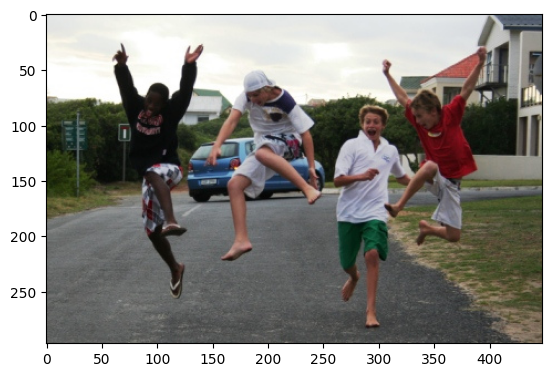

In [53]:
generate_caption('395461421_c586b136de.jpg')

I0000 00:00:1747756060.100650  468991 service.cc:148] XLA service 0x774368639e40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747756060.100675  468991 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2025-05-20 21:17:40.128666: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747756061.816642  468991 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


--------------------Predicted--------------------
startseq people are walking down street street endseq


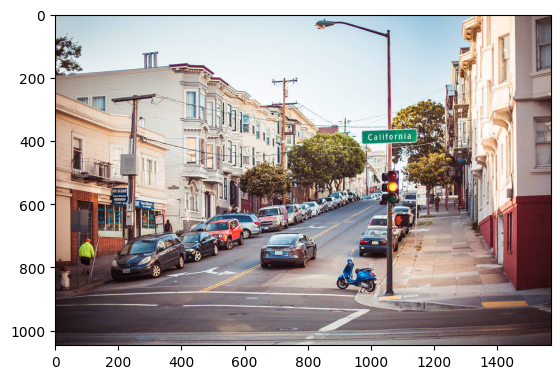

In [59]:
generate_caption_2('/tmp/test.jpg')